In [7]:
import pandas as pd
import os

# Set the path to the Data folder
data_path = "/Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/Data"

# Load the first CSV file (heart_diagnoses_1.csv)
first_csv = "heart_diagnoses_1.csv"
df = pd.read_csv(os.path.join(data_path, first_csv))

# Display the head of the dataframe
print(f"Loading {first_csv}:")
print(df.head())


Loading heart_diagnoses_1.csv:
          note_id  subject_id   hadm_id note_type  note_seq  \
0  10000980-DS-20    10000980  29654838        DS        20   
1  10000980-DS-21    10000980  26913865        DS        21   
2   10002013-DS-8    10002013  24760295        DS         8   
3   10002155-DS-8    10002155  23822395        DS         8   
4  10004457-DS-10    10004457  28723315        DS        10   

             charttime            storetime  \
0  2188-01-06 03:00:00  2188-01-07 23:49:00   
1  2189-07-04 03:00:00  2189-07-04 22:50:00   
2  2160-07-13 03:00:00  2160-07-15 16:59:00   
3  2129-08-19 03:00:00  2129-08-20 15:29:00   
4  2141-08-14 03:00:00  2141-08-14 21:50:00   

                                                 HPI  \
0  :\n___ yo woman with h/o hypertension, hyperli...   
1  :\nThis is a ___ M with history of diabetes, d...   
2  :\n___ w/ PMH of CAD s/p PCI x3, s/p off-pump ...   
3  :\n___ is a ___ yo female with a past medical ...   
4  :\nMr. ___ is a ___ with

In [8]:
# Load the second CSV file (laboratory_events_codes_2.csv)
second_csv = "laboratory_events_codes_2.csv"
df2 = pd.read_csv(os.path.join(data_path, second_csv))

# Display the head of the second dataframe
print(f"Loading {second_csv}:")
print(df2.head())


Loading laboratory_events_codes_2.csv:
      hadm_id            charttime value  valuenum valueuom  ref_range_lower  \
0  29654838.0  2188-01-04 23:43:00   ___    198.00     IU/L             29.0   
1  29654838.0  2188-01-04 23:43:00     5      5.00    ng/mL              0.0   
2  29654838.0  2188-01-04 23:43:00   ___      0.03    ng/mL              0.0   
3  29654838.0  2188-01-05 06:56:00   1.2      1.20      NaN              0.9   
4  29654838.0  2188-01-05 06:56:00  12.8     12.80      sec              9.4   

   ref_range_upper      flag                          label  fluid  \
0           201.00       NaN           Creatine Kinase (CK)  Blood   
1            10.00       NaN  Creatine Kinase, MB Isoenzyme  Blood   
2             0.01  abnormal                     Troponin T  Blood   
3             1.10  abnormal                        INR(PT)  Blood   
4            12.50  abnormal                             PT  Blood   

            examination_group analysis_batch_id qc_flag ref

In [9]:
# Load the third CSV file (microbiology_events_codes_3.csv)
third_csv = "microbiology_events_codes_3.csv"
df3 = pd.read_csv(os.path.join(data_path, third_csv))

# Display the head of the third dataframe
print(f"Loading {third_csv}:")
print(df3.head())


Loading microbiology_events_codes_3.csv:
   subject_id     hadm_id            chartdate            charttime  \
0    10000980  26913865.0  2189-06-27 00:00:00  2189-06-27 10:52:00   
1    10002155  23822395.0  2129-08-04 00:00:00  2129-08-04 17:04:00   
2    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 15:54:00   
3    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 18:43:00   
4    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 18:43:00   

  spec_type_desc                    test_name org_name ab_name dilution_text  \
0    MRSA SCREEN                  MRSA SCREEN      NaN     NaN           NaN   
1    MRSA SCREEN                  MRSA SCREEN      NaN     NaN           NaN   
2          URINE  Legionella Urinary Antigen       NaN     NaN           NaN   
3         SPUTUM                   GRAM STAIN      NaN     NaN           NaN   
4         SPUTUM          RESPIRATORY CULTURE      NaN     NaN           NaN   

  dilution_comparison  dilution_value interpretatio

In [10]:
# Load the fourth CSV file (procedure_code_4.csv)
fourth_csv = "procedure_code_4.csv"
df4 = pd.read_csv(os.path.join(data_path, fourth_csv))

# Display the head of the fourth dataframe
print(f"Loading {fourth_csv}:")
print(df4.head())


Loading procedure_code_4.csv:
   subject_id   hadm_id  seq_num            chartdate icd_code  \
0    10000980  26913865        1  2189-07-01 03:00:00     0066   
1    10000980  26913865        2  2189-07-01 03:00:00     3607   
2    10000980  26913865        3  2189-07-01 03:00:00     0045   
3    10000980  26913865        4  2189-07-01 03:00:00     0041   
4    10000980  26913865        5  2189-07-01 03:00:00     3722   

                                          long_title  
0  Percutaneous transluminal coronary angioplasty...  
1  Insertion of drug-eluting coronary artery sten...  
2                    Insertion of one vascular stent  
3                           Procedure on two vessels  
4                 Left heart cardiac catheterization  


In [11]:
# Let's examine the structure and data types of each dataset
print("=== DATASET 1: Heart Diagnoses ===")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")
print(f"\nSample values:")
print(df.head())

print("\n" + "="*50)
print("=== DATASET 2: Laboratory Events Codes ===")
print(f"Shape: {df2.shape}")
print(f"Columns: {list(df2.columns)}")
print(f"Data types:\n{df2.dtypes}")
print(f"\nSample values:")
print(df2.head())

print("\n" + "="*50)
print("=== DATASET 3: Microbiology Events Codes ===")
print(f"Shape: {df3.shape}")
print(f"Columns: {list(df3.columns)}")
print(f"Data types:\n{df3.dtypes}")
print(f"\nSample values:")
print(df3.head())

print("\n" + "="*50)
print("=== DATASET 4: Procedure Codes ===")
print(f"Shape: {df4.shape}")
print(f"Columns: {list(df4.columns)}")
print(f"Data types:\n{df4.dtypes}")
print(f"\nSample values:")
print(df4.head())


=== DATASET 1: Heart Diagnoses ===
Shape: (4864, 25)
Columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint', 'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI', 'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age', 'anchor_year', 'dod']
Data types:
note_id             object
subject_id           int64
hadm_id              int64
note_type           object
note_seq             int64
charttime           object
storetime           object
HPI                 object
physical_exam       object
chief_complaint     object
invasions           object
X-ray               object
CT                  object
Ultrasound          object
CATH                object
ECG                 object
MRI                 object
reports             object
subject_id_dx        int64
icd_code            object
long_title          object
gender              object
age                float64
anchor_year      

In [12]:
# Let's identify numerical variables that would be good for distribution plots
import numpy as np

def analyze_numerical_variables(dataframe, name):
    print(f"\n=== {name} - NUMERICAL VARIABLES ANALYSIS ===")
    
    # Get numerical columns
    numerical_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    
    if numerical_cols:
        print(f"Numerical columns: {numerical_cols}")
        
        # Show basic statistics for numerical variables
        print("\nBasic statistics:")
        print(dataframe[numerical_cols].describe())
        
        # Check for variables that might be good for distribution plots
        print(f"\nVariables suitable for distribution plots:")
        for col in numerical_cols:
            unique_count = dataframe[col].nunique()
            null_count = dataframe[col].isnull().sum()
            print(f"  - {col}: {unique_count} unique values, {null_count} nulls")
            
            # Check if it's continuous (many unique values) vs categorical (few unique values)
            if unique_count > 10 and unique_count < len(dataframe) * 0.5:
                print(f"    → Good candidate for distribution plot (continuous-like)")
            elif unique_count <= 10:
                print(f"    → Better for bar plot (categorical-like)")
    else:
        print("No numerical columns found")
    
    return numerical_cols

# Analyze each dataset
num_cols_1 = analyze_numerical_variables(df, "HEART DIAGNOSES")
num_cols_2 = analyze_numerical_variables(df2, "LABORATORY EVENTS")
num_cols_3 = analyze_numerical_variables(df3, "MICROBIOLOGY EVENTS")
num_cols_4 = analyze_numerical_variables(df4, "PROCEDURE CODES")



=== HEART DIAGNOSES - NUMERICAL VARIABLES ANALYSIS ===
Numerical columns: ['subject_id', 'hadm_id', 'note_seq', 'subject_id_dx', 'age', 'anchor_year']

Basic statistics:
         subject_id       hadm_id     note_seq  subject_id_dx          age  \
count  4.864000e+03  4.864000e+03  4864.000000   4.864000e+03  1363.000000   
mean   1.510717e+07  2.501745e+07    14.690995   1.500158e+07    68.978723   
std    2.938761e+06  2.873736e+06     8.260520   2.879841e+06    14.973358   
min    1.000098e+07  2.000446e+07     2.000000   1.000098e+07    18.000000   
25%    1.252385e+07  2.260252e+07     9.000000   1.246683e+07    60.000000   
50%    1.507553e+07  2.503238e+07    14.000000   1.498641e+07    70.000000   
75%    1.764939e+07  2.746833e+07    19.000000   1.750476e+07    81.000000   
max    1.999860e+07  2.999967e+07    94.000000   1.999850e+07    95.000000   

       anchor_year  
count  1363.000000  
mean   2155.620690  
std      23.400097  
min    2110.000000  
25%    2136.000000  


In [13]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")


In [14]:
# Function to create distribution plots for numerical variables
def plot_distributions(dataframe, dataset_name, max_vars=4):
    """Plot distributions for numerical variables that are suitable for this type of visualization"""
    
    # Get numerical columns
    numerical_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    
    if not numerical_cols:
        print(f"No numerical variables found in {dataset_name}")
        return
    
    # Filter for variables suitable for distribution plots
    suitable_vars = []
    for col in numerical_cols:
        unique_count = dataframe[col].nunique()
        null_count = dataframe[col].isnull().sum()
        total_count = len(dataframe)
        
        # Good candidates: many unique values, not too many nulls, not too categorical
        if (unique_count > 10 and 
            unique_count < total_count * 0.8 and 
            null_count < total_count * 0.5):
            suitable_vars.append(col)
    
    if not suitable_vars:
        print(f"No suitable variables found for distribution plots in {dataset_name}")
        return
    
    # Limit to max_vars to avoid overcrowding
    suitable_vars = suitable_vars[:max_vars]
    
    # Create subplots
    n_vars = len(suitable_vars)
    if n_vars == 1:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes = [axes]
    elif n_vars == 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    elif n_vars == 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
    
    fig.suptitle(f'Distribution Plots - {dataset_name}', fontsize=16, fontweight='bold')
    
    for i, col in enumerate(suitable_vars):
        ax = axes[i]
        
        # Remove null values for plotting
        data_to_plot = dataframe[col].dropna()
        
        if len(data_to_plot) > 0:
            # Create histogram with density curve
            ax.hist(data_to_plot, bins=30, alpha=0.7, density=True, color='skyblue', edgecolor='black')
            
            # Add density curve
            try:
                from scipy import stats
                kde = stats.gaussian_kde(data_to_plot)
                x_range = np.linspace(data_to_plot.min(), data_to_plot.max(), 100)
                ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='Density')
                ax.legend()
            except:
                pass
            
            # Add statistics text
            mean_val = data_to_plot.mean()
            std_val = data_to_plot.std()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
            
            ax.set_title(f'{col}\n(n={len(data_to_plot)}, μ={mean_val:.2f}, σ={std_val:.2f})')
            ax.set_xlabel(col)
            ax.set_ylabel('Density')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{col} (No Data)')
    
    # Hide empty subplots
    for i in range(len(suitable_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{dataset_name} - Summary Statistics:")
    print(dataframe[suitable_vars].describe())


Creating distribution plots for all datasets...


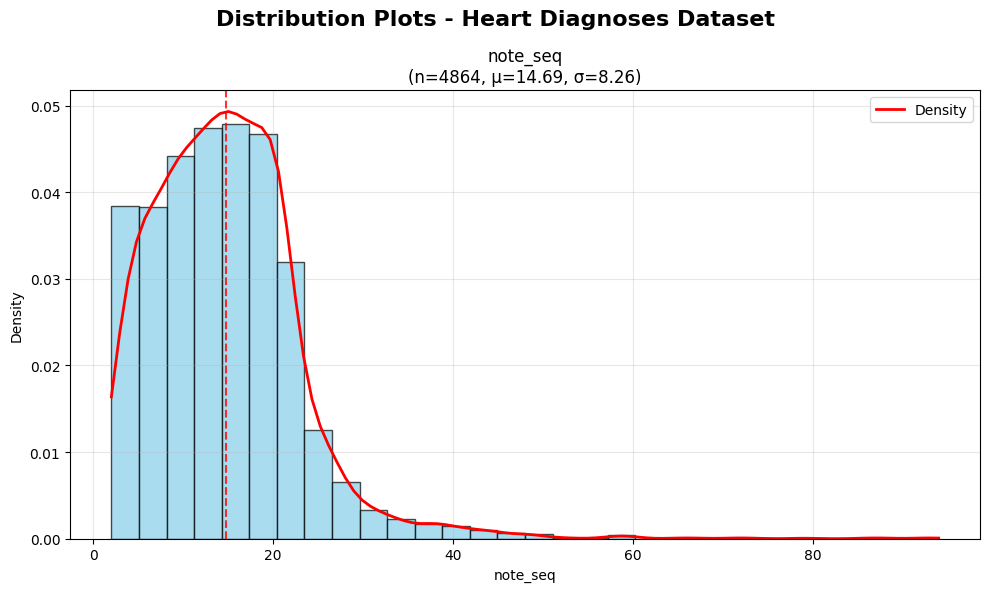


Heart Diagnoses Dataset - Summary Statistics:
          note_seq
count  4864.000000
mean     14.690995
std       8.260520
min       2.000000
25%       9.000000
50%      14.000000
75%      19.000000
max      94.000000


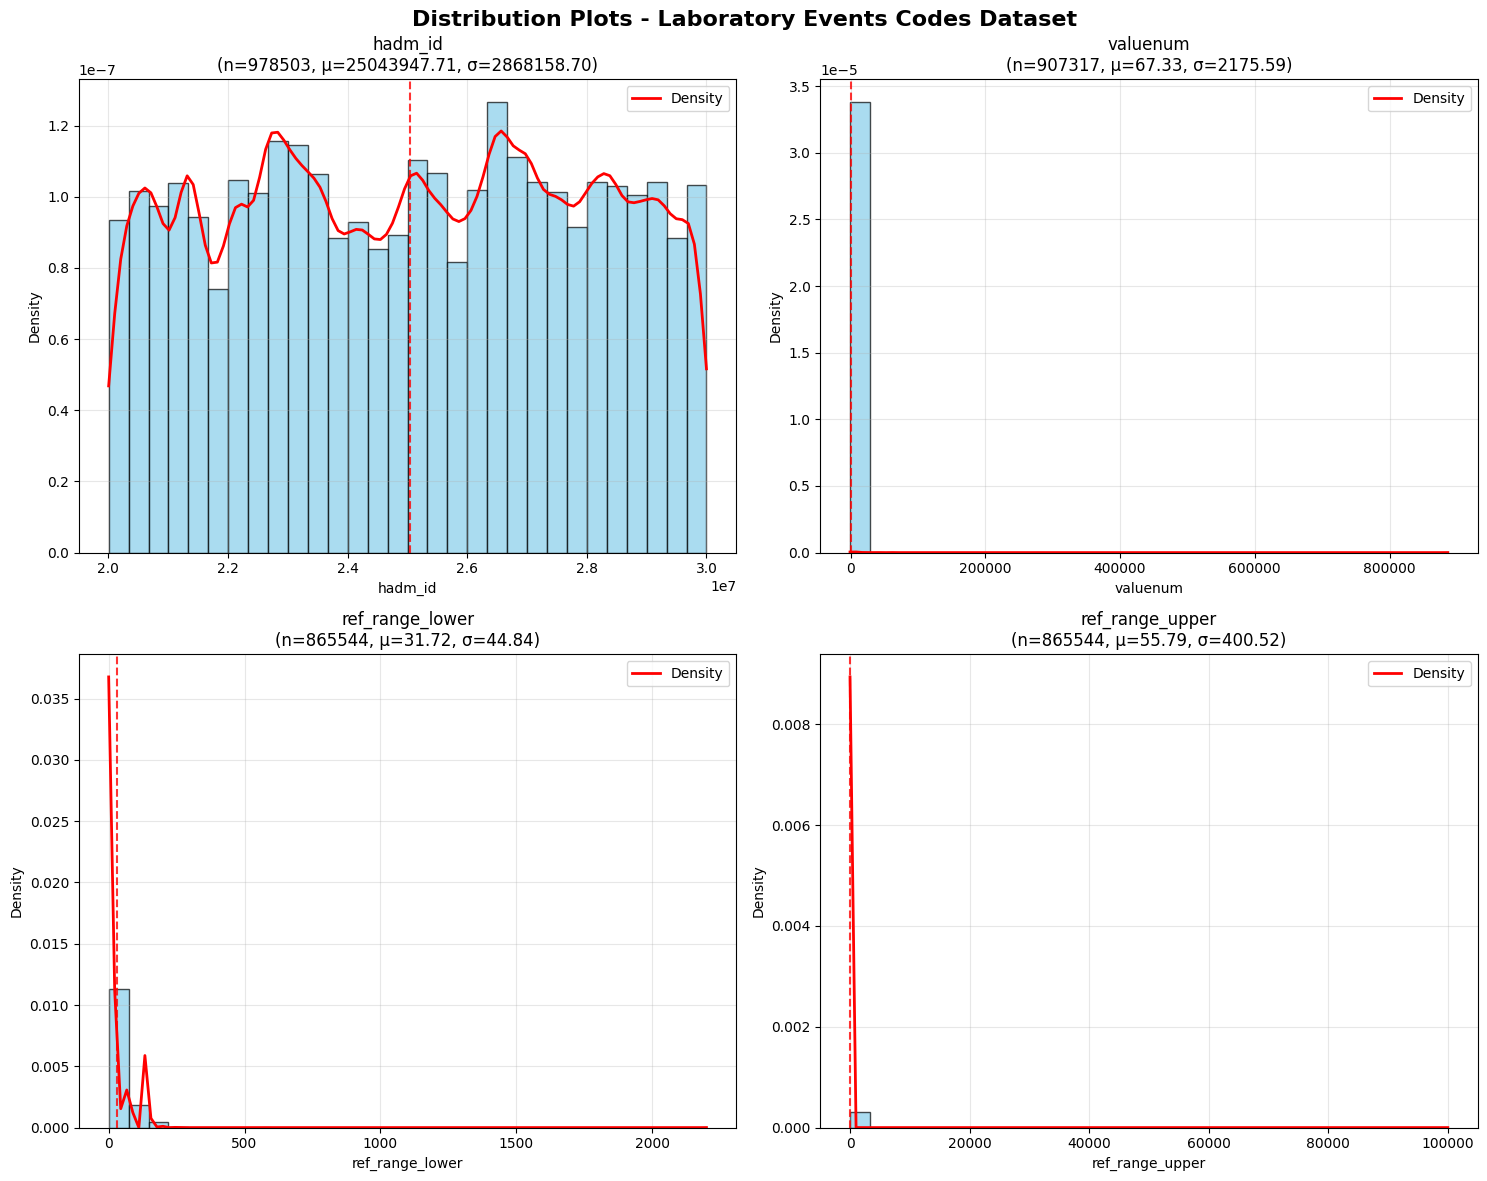


Laboratory Events Codes Dataset - Summary Statistics:
            hadm_id       valuenum  ref_range_lower  ref_range_upper
count  9.785030e+05  907317.000000    865544.000000    865544.000000
mean   2.504395e+07      67.332325        31.724619        55.794861
std    2.868159e+06    2175.589189        44.840840       400.515033
min    2.000446e+07    -743.000000         0.000000         0.000000
25%    2.261232e+07       4.300000         3.300000         5.400000
50%    2.510567e+07      17.000000        10.400000        20.000000
75%    2.749772e+07      60.200000        36.000000        52.000000
max    2.999967e+07  886449.000000      2200.000000    100000.000000


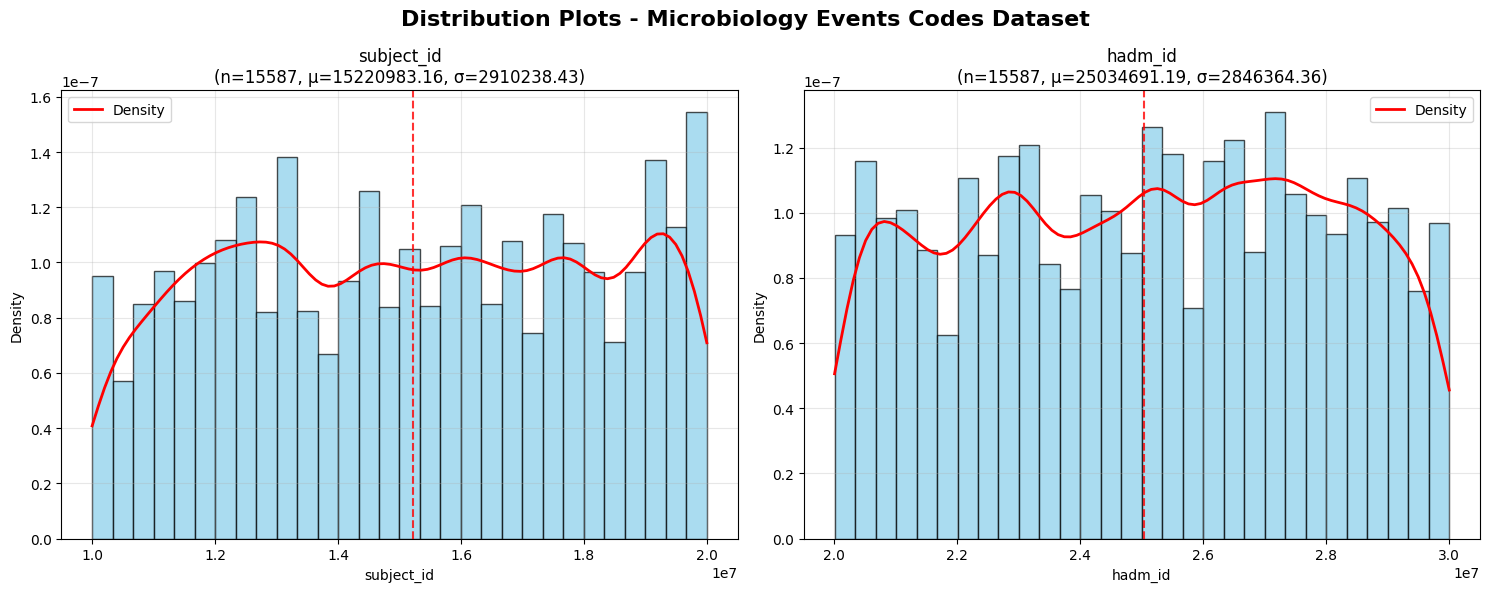


Microbiology Events Codes Dataset - Summary Statistics:
         subject_id       hadm_id
count  1.558700e+04  1.558700e+04
mean   1.522098e+07  2.503469e+07
std    2.910238e+06  2.846364e+06
min    1.000098e+07  2.000790e+07
25%    1.266277e+07  2.266346e+07
50%    1.519823e+07  2.514649e+07
75%    1.772189e+07  2.743116e+07
max    1.999767e+07  2.999967e+07


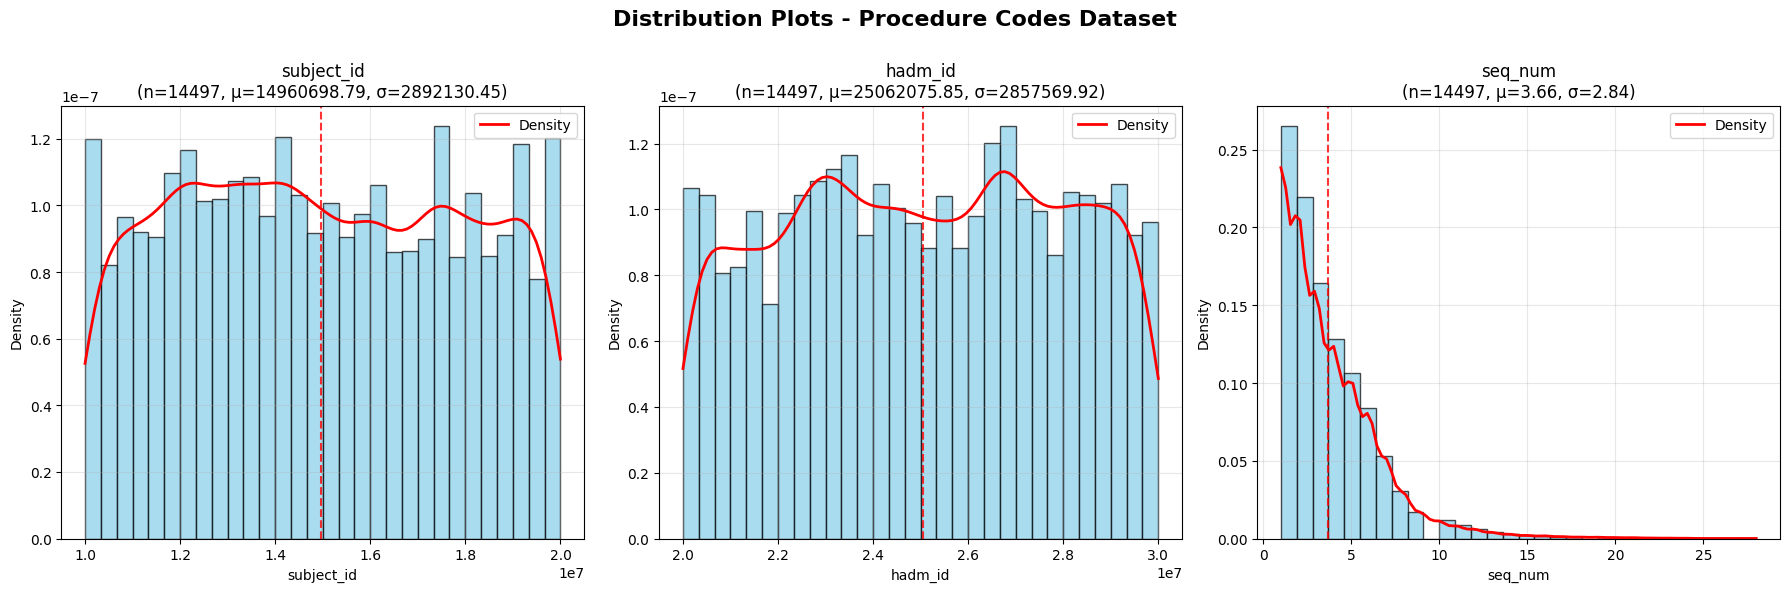


Procedure Codes Dataset - Summary Statistics:
         subject_id       hadm_id       seq_num
count  1.449700e+04  1.449700e+04  14497.000000
mean   1.496070e+07  2.506208e+07      3.661102
std    2.892130e+06  2.857570e+06      2.841640
min    1.000098e+07  2.000790e+07      1.000000
25%    1.249274e+07  2.268042e+07      2.000000
50%    1.486272e+07  2.507288e+07      3.000000
75%    1.745891e+07  2.750236e+07      5.000000
max    1.999850e+07  2.999967e+07     28.000000


In [15]:
# Create distribution plots for all datasets
print("Creating distribution plots for all datasets...")
print("="*60)

# Plot distributions for each dataset
plot_distributions(df, "Heart Diagnoses Dataset")
plot_distributions(df2, "Laboratory Events Codes Dataset")
plot_distributions(df3, "Microbiology Events Codes Dataset")
plot_distributions(df4, "Procedure Codes Dataset")


In [16]:
# Let's examine df1 more closely and focus on meaningful variables
print("=== FOCUSED ANALYSIS OF HEART DIAGNOSES DATASET (df1) ===")
print(f"Dataset shape: {df.shape}")
print(f"All columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")
print("\nFirst few rows:")
print(df.head())


=== FOCUSED ANALYSIS OF HEART DIAGNOSES DATASET (df1) ===
Dataset shape: (4864, 25)
All columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint', 'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI', 'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age', 'anchor_year', 'dod']
Data types:
note_id             object
subject_id           int64
hadm_id              int64
note_type           object
note_seq             int64
charttime           object
storetime           object
HPI                 object
physical_exam       object
chief_complaint     object
invasions           object
X-ray               object
CT                  object
Ultrasound          object
CATH                object
ECG                 object
MRI                 object
reports             object
subject_id_dx        int64
icd_code            object
long_title          object
gender              object
age      

In [17]:
# Let's examine the specific variables you mentioned
print("=== EXAMINING TARGET VARIABLES ===")

# Check if these columns exist and their current data types
target_vars = ['charttime', 'storetime', 'gender', 'age', 'icd_code']
existing_vars = []

for var in target_vars:
    if var in df.columns:
        existing_vars.append(var)
        print(f"\n{var.upper()}:")
        print(f"  Data type: {df[var].dtype}")
        print(f"  Non-null count: {df[var].count()}")
        print(f"  Null count: {df[var].isnull().sum()}")
        print(f"  Unique values: {df[var].nunique()}")
        print(f"  Sample values: {df[var].head(10).tolist()}")
    else:
        print(f"\n{var.upper()}: Column not found")
        
print(f"\nFound variables: {existing_vars}")


=== EXAMINING TARGET VARIABLES ===

CHARTTIME:
  Data type: object
  Non-null count: 4864
  Null count: 0
  Unique values: 4466
  Sample values: ['2188-01-06 03:00:00', '2189-07-04 03:00:00', '2160-07-13 03:00:00', '2129-08-19 03:00:00', '2141-08-14 03:00:00', '2167-11-12 03:00:00', '2164-05-31 03:00:00', '2146-03-22 03:00:00', '2167-11-15 03:00:00', '2138-05-01 03:00:00']

STORETIME:
  Data type: object
  Non-null count: 4864
  Null count: 0
  Unique values: 4761
  Sample values: ['2188-01-07 23:49:00', '2189-07-04 22:50:00', '2160-07-15 16:59:00', '2129-08-20 15:29:00', '2141-08-14 21:50:00', '2167-11-13 14:39:00', '2164-06-24 13:20:00', '2146-03-23 16:42:00', '2167-11-18 21:36:00', '2138-05-03 19:23:00']

GENDER:
  Data type: object
  Non-null count: 1363
  Null count: 3501
  Unique values: 2
  Sample values: ['F', 'F', nan, nan, 'M', 'M', nan, nan, nan, nan]

AGE:
  Data type: float64
  Non-null count: 1363
  Null count: 3501
  Unique values: 75
  Sample values: [75.0, 75.0, nan, n

In [24]:
# Data preprocessing and conversion for meaningful analysis
from datetime import datetime
import pandas as pd

# Create a copy for analysis
df_analysis = df.copy()

print("=== DATA PREPROCESSING ===")

# 1. Convert charttime and storetime to datetime if they're not already
datetime_vars = ['charttime', 'storetime']
for var in datetime_vars:
    if var in df_analysis.columns:
        print(f"\nProcessing {var}...")
        try:
            # Try to convert to datetime
            df_analysis[f'{var}_datetime'] = pd.to_datetime(df_analysis[var], errors='coerce')
            
            # Extract numerical components for analysis
            df_analysis[f'{var}_hour'] = df_analysis[f'{var}_datetime'].dt.hour
            df_analysis[f'{var}_day_of_week'] = df_analysis[f'{var}_datetime'].dt.dayofweek
            df_analysis[f'{var}_day_of_year'] = df_analysis[f'{var}_datetime'].dt.dayofyear
            
            print(f"  Converted to datetime, extracted hour/day components")
            print(f"  Sample hours: {df_analysis[f'{var}_hour'].dropna().head().tolist()}")
            
        except Exception as e:
            print(f"  Could not convert {var} to datetime: {e}")

# 2. Handle gender (categorical to numerical)
if 'gender' in df_analysis.columns:
    print(f"\nProcessing gender...")
    print(f"  Original values: {df_analysis['gender'].value_counts()}")
    
    # Create categorical and track the mapping
    gender_cat = pd.Categorical(df_analysis['gender'])
    df_analysis['gender_numeric'] = gender_cat.codes
    
    # Show the mapping between original values and numeric codes
    print(f"  Gender mapping:")
    for i, category in enumerate(gender_cat.categories):
        print(f"    {category} → {i}")
    
    # Handle NaN values (they get code -1)
    nan_count = df_analysis['gender'].isnull().sum()
    if nan_count > 0:
        print(f"    NaN → -1 (count: {nan_count})")
    
    print(f"  Converted to numeric: {df_analysis['gender_numeric'].value_counts()}")

# 3. Handle age (might need conversion)
if 'age' in df_analysis.columns:
    print(f"\nProcessing age...")
    print(f"  Current data type: {df_analysis['age'].dtype}")
    print(f"  Sample values: {df_analysis['age'].dropna().head(10).tolist()}")
    
    # If age is not numeric, try to convert
    if df_analysis['age'].dtype == 'object':
        # Try to extract numeric values
        df_analysis['age_numeric'] = pd.to_numeric(df_analysis['age'], errors='coerce')
        print(f"  Converted to numeric, sample: {df_analysis['age_numeric'].dropna().head().tolist()}")
    else:
        df_analysis['age_numeric'] = df_analysis['age']

# 4. Handle ICD codes (categorical analysis)
if 'icd_code' in df_analysis.columns:
    print(f"\nProcessing ICD codes...")
    print(f"  Total unique codes: {df_analysis['icd_code'].nunique()}")
    print(f"  Most common codes:")
    print(df_analysis['icd_code'].value_counts().head(10))
    
    # Create frequency-based encoding for ICD codes
    icd_counts = df_analysis['icd_code'].value_counts()
    df_analysis['icd_code_frequency'] = df_analysis['icd_code'].map(icd_counts)
    print(f"  Created frequency encoding for ICD codes")

print(f"\nNew analysis dataset shape: {df_analysis.shape}")
print(f"New columns created: {[col for col in df_analysis.columns if col not in df.columns]}")


=== DATA PREPROCESSING ===

Processing charttime...
  Converted to datetime, extracted hour/day components
  Sample hours: [3, 3, 3, 3, 3]

Processing storetime...
  Converted to datetime, extracted hour/day components
  Sample hours: [23, 22, 16, 15, 21]

Processing gender...
  Original values: gender
M    781
F    582
Name: count, dtype: int64
  Gender mapping:
    F → 0
    M → 1
    NaN → -1 (count: 3501)
  Converted to numeric: gender_numeric
-1    3501
 1     781
 0     582
Name: count, dtype: int64

Processing age...
  Current data type: float64
  Sample values: [75.0, 75.0, 66.0, 48.0, 48.0, 53.0, 71.0, 73.0, 70.0, 54.0]

Processing ICD codes...
  Total unique codes: 20
  Most common codes:
icd_code
I50    1447
I21    1434
I25     645
I48     438
I35     231
I31     153
I47     130
I30      83
I44      70
I34      50
Name: count, dtype: int64
  Created frequency encoding for ICD codes

New analysis dataset shape: (4864, 36)
New columns created: ['charttime_datetime', 'charttime

Variables to plot: ['charttime_hour', 'storetime_hour', 'gender_numeric', 'age_numeric', 'icd_code_frequency']
Number of variables: 5


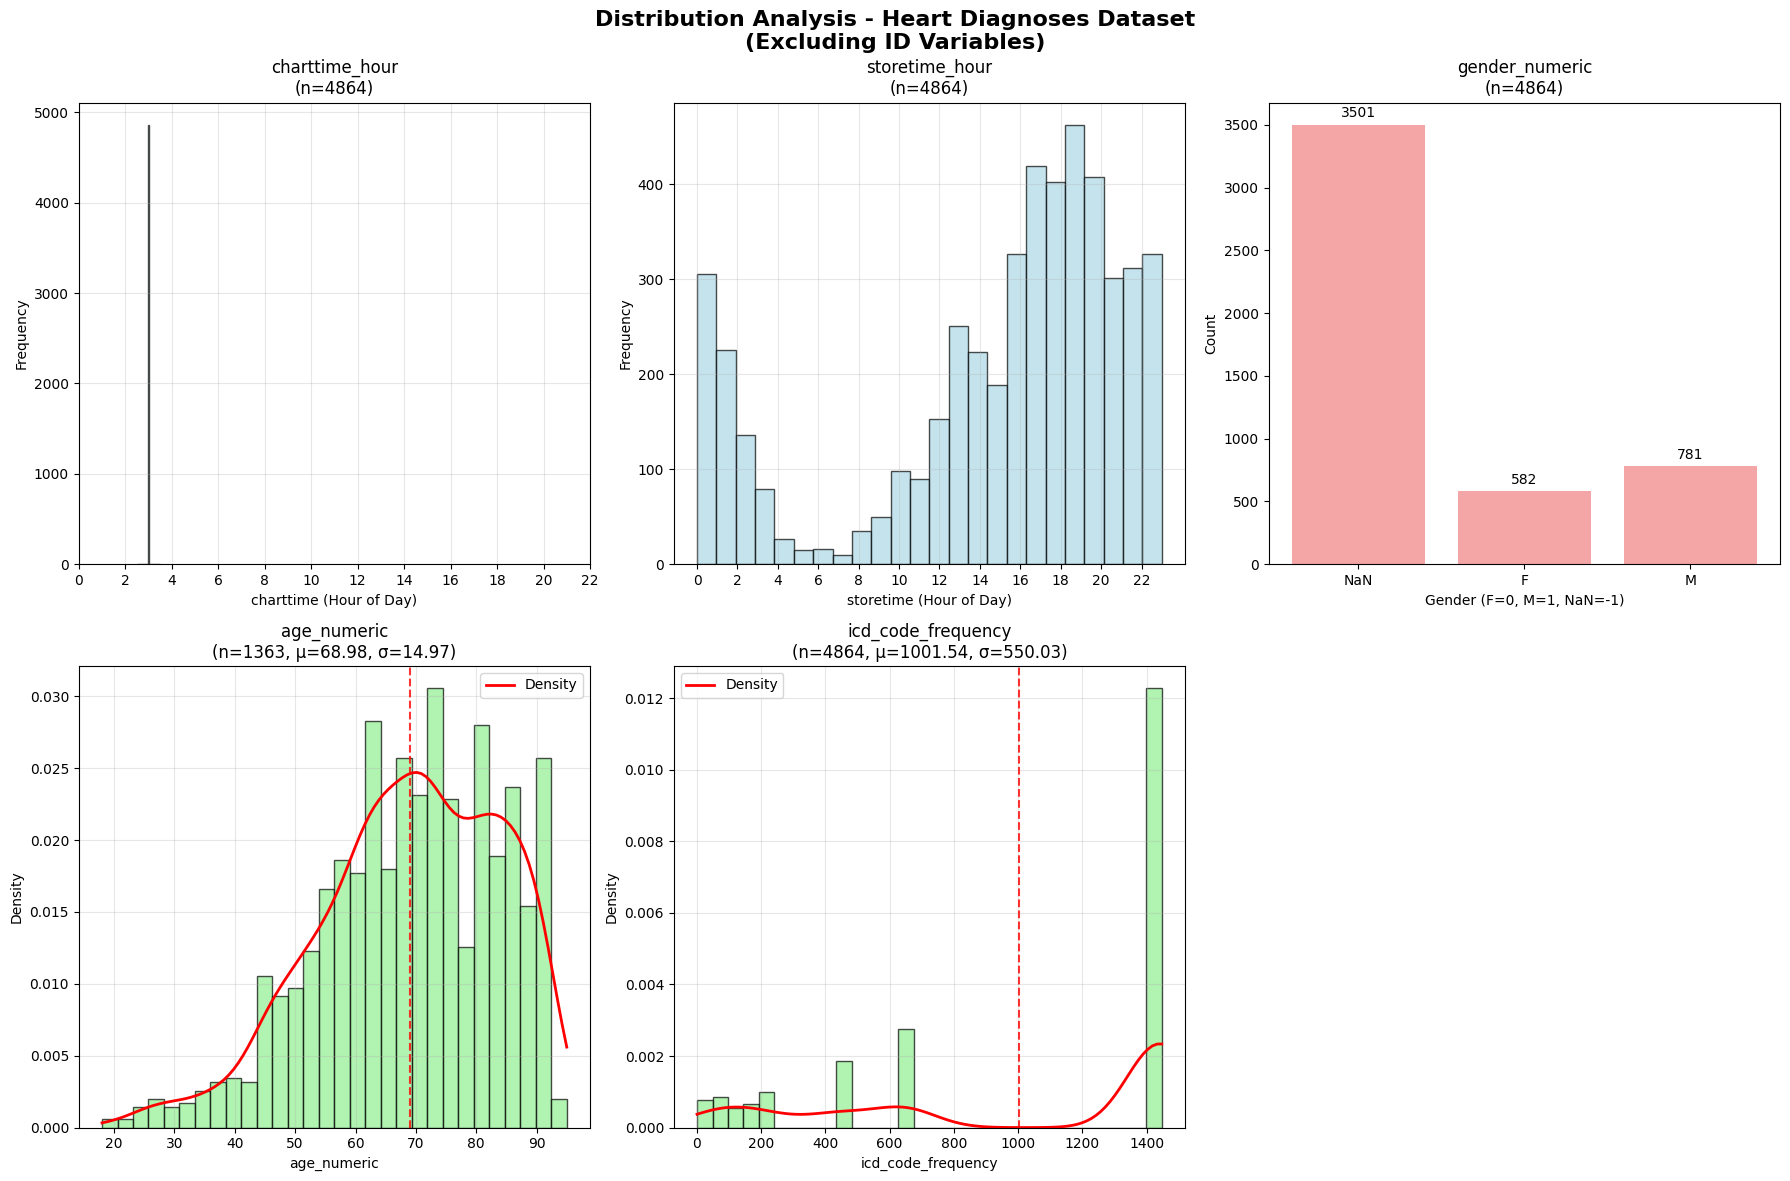


=== SUMMARY STATISTICS ===

charttime_hour:
  Count: 4864
  Mean: 3.00
  Std: 0.00
  Min: 3
  Max: 3
  Value counts:
charttime_hour
3    4864
Name: count, dtype: int64

storetime_hour:
  Count: 4864
  Mean: 14.83
  Std: 6.94
  Min: 0
  Max: 23
  Value counts:
storetime_hour
0     306
1     226
2     136
3      79
4      27
5      15
6      16
7      10
8      35
9      50
10     98
11     90
12    153
13    251
14    223
15    189
16    327
17    419
18    403
19    463
20    408
21    301
22    312
23    327
Name: count, dtype: int64

gender_numeric:
  Count: 4864
  Mean: -0.56
  Std: 0.75
  Min: -1
  Max: 1
  Value counts:
gender_numeric
-1    3501
 0     582
 1     781
Name: count, dtype: int64

age_numeric:
  Count: 1363
  Mean: 68.98
  Std: 14.97
  Min: 18.0
  Max: 95.0

icd_code_frequency:
  Count: 4864
  Mean: 1001.54
  Std: 550.03
  Min: 1
  Max: 1447


In [28]:
# Create focused distribution plots for the meaningful variables
def plot_focused_distributions():
    """Create distribution plots for the processed meaningful variables"""
    
    # Define the variables we want to plot (excluding ID variables)
    plot_vars = []
    
    # Time variables (hour distributions)
    time_vars = ['charttime_hour', 'storetime_hour']
    for var in time_vars:
        if var in df_analysis.columns:
            plot_vars.append(var)
    
    # Demographic variables
    demo_vars = ['gender_numeric', 'age_numeric']
    for var in demo_vars:
        if var in df_analysis.columns:
            plot_vars.append(var)
    
    # ICD code frequency
    if 'icd_code_frequency' in df_analysis.columns:
        plot_vars.append('icd_code_frequency')
    
    if not plot_vars:
        print("No suitable variables found for plotting")
        return
    
    print(f"Variables to plot: {plot_vars}")
    print(f"Number of variables: {len(plot_vars)}")
    
    # Create subplots
    n_vars = len(plot_vars)
    if n_vars == 1:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes = [axes]
    elif n_vars == 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    elif n_vars == 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    elif n_vars == 4:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
    else:
        # For more than 4 variables, create a larger grid
        rows = (n_vars + 2) // 3  # Ceiling division
        fig, axes = plt.subplots(rows, 3, figsize=(18, 6*rows))
        if rows == 1:
            axes = [axes] if n_vars == 1 else axes
        else:
            axes = axes.flatten()
    
    fig.suptitle('Distribution Analysis - Heart Diagnoses Dataset\n(Excluding ID Variables)', 
                 fontsize=16, fontweight='bold')
    
    for i, col in enumerate(plot_vars):
        ax = axes[i]
        data_to_plot = df_analysis[col].dropna()
        
        if len(data_to_plot) > 0:
            if col in ['gender_numeric']:
                # For categorical-like variables, use bar plot
                value_counts = data_to_plot.value_counts().sort_index()
                bars = ax.bar(value_counts.index, value_counts.values, alpha=0.7, color='lightcoral')
                
                # Set custom x-axis labels for gender
                gender_labels = []
                gender_ticks = []
                for idx in value_counts.index:
                    if idx == -1:
                        gender_labels.append('NaN')
                    elif idx == 0:
                        gender_labels.append('F')
                    elif idx == 1:
                        gender_labels.append('M')
                    else:
                        gender_labels.append(f'Code {idx}')
                    gender_ticks.append(idx)
                
                ax.set_xticks(gender_ticks)
                ax.set_xticklabels(gender_labels)
                ax.set_xlabel('Gender (F=0, M=1, NaN=-1)')
                ax.set_ylabel('Count')
                ax.set_title(f'{col}\n(n={len(data_to_plot)})')
                
                # Add value labels on bars
                for bar, count in zip(bars, value_counts.values):
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values)*0.01,
                           str(count), ha='center', va='bottom')
                
            elif col in ['charttime_hour', 'storetime_hour']:
                # For time variables, use histogram with special formatting
                ax.hist(data_to_plot, bins=24, alpha=0.7, color='lightblue', edgecolor='black')
                ax.set_xlabel(f'{col.split("_")[0]} (Hour of Day)')
                ax.set_ylabel('Frequency')
                ax.set_title(f'{col}\n(n={len(data_to_plot)})')
                ax.set_xticks(range(0, 24, 2))
                ax.grid(True, alpha=0.3)
                
            else:
                # For continuous variables, use histogram with density curve
                ax.hist(data_to_plot, bins=30, alpha=0.7, density=True, color='lightgreen', edgecolor='black')
                
                # Add density curve
                try:
                    from scipy import stats
                    kde = stats.gaussian_kde(data_to_plot)
                    x_range = np.linspace(data_to_plot.min(), data_to_plot.max(), 100)
                    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='Density')
                    ax.legend()
                except:
                    pass
                
                mean_val = data_to_plot.mean()
                std_val = data_to_plot.std()
                ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
                ax.set_title(f'{col}\n(n={len(data_to_plot)}, μ={mean_val:.2f}, σ={std_val:.2f})')
                ax.set_xlabel(col)
                ax.set_ylabel('Density')
                ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{col} (No Data)')
    
    # Hide empty subplots
    for i in range(len(plot_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('plots/task1.1_df1-heart_diag.jpg')
    plt.show()
    
    # Print summary for each variable
    print("\n=== SUMMARY STATISTICS ===")
    for col in plot_vars:
        if col in df_analysis.columns:
            data = df_analysis[col].dropna()
            print(f"\n{col}:")
            print(f"  Count: {len(data)}")
            print(f"  Mean: {data.mean():.2f}")
            print(f"  Std: {data.std():.2f}")
            print(f"  Min: {data.min()}")
            print(f"  Max: {data.max()}")
            if col in ['gender_numeric', 'charttime_hour', 'storetime_hour']:
                print(f"  Value counts:")
                print(data.value_counts().sort_index())

# Create the focused distribution plots
plot_focused_distributions()
